In [271]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
import en_core_web_lg
from tqdm import tqdm, tqdm_notebook
import spacy
from sklearn.metrics import classification_report
import numpy as np

pd.set_option('display.max_colwidth', 300)

# Description
### The idea
The idea is to align sentences and make some features based on wordnet synsets relationship (synonym, hyponym, hypernym, meronym, holonym, ...). To make true alignment is somewhat a big task, which need it's own (not so trivial) classifier. So I want to simplify step of allignment to this procedure:
  * for each pair of sentences
      * match each word in evidence sentence with each word in hypothesis
      * for each match $(e_i, h_j)$
          * compute following features:
              * if $e_i$ is synonym for $h_i$ return 1 else 0
              * if $e_i$ in the hypernym closure from $h_j$ to root return 1 else 0
              * if $h_j$ in the hypernym closure from $e_i$ to root return 1 else 0
              * if $e_i$ in the holonym closure from $h_j$ to root return 1 else 0
              * if $h_j$ in the meronym closure from $e_i$ to root return 1 else 0
              * if $e_i$ in the entailment closure from $h_j$ to root return 1 else 0
              * if $h_j$ in the entailment closure from $e_i$ to root return 1 else 0
          * penalize each features by the distance between $i$ and $j$: $| j - i | + 1$
      * sum all results to have one number for each sentence pair
      
Simply speaking, this algorithm takes assumption that if word in evidence and hypothesis is aligned  it is very unlikely that they will be very far from each other. It is definetely not true, but we'll see how it works.

### Baseline
For baseline I will use simply a Logistic Regression and classifier on tf-idf word features for two sentences concatenated.

### Steps
* Train classifier only on wordnet features
* Train classifier only on word embeddings
* Train classifier on both word embeddings and wordnet features

# Data loading

In [8]:
nlp = en_core_web_lg.load()

In [23]:
plt.style.use('dark_background')

In [9]:
TRAIN_FILE = 'dataset/snli_1.0/snli_1.0_train.jsonl'
TEST_FILE = 'dataset/snli_1.0/snli_1.0_test.jsonl'

In [60]:
def prepare(file):
    rows = [json.loads(line) for line in open(file)]
    df = pd.DataFrame({
        'sentence1': [r['sentence1'] for r in rows],
        'sentence2': [r['sentence2'] for r in rows],
        'sentence1_parse': [r['sentence1_parse'] for r in rows],
        'sentence2_parse': [r['sentence2_parse'] for r in rows],
        'label': [r['gold_label'] for r in rows]
    })
    return df[df['label'] != '-'].copy()

In [61]:
train = prepare(TRAIN_FILE)

In [62]:
test = prepare(TEST_FILE)

In [35]:
train[:6]

,label,sentence1,sentence2
0,neutral,A person on a horse jumps over a broken down airplane.,A person is training his horse for a competition.
1,contradiction,A person on a horse jumps over a broken down airplane.,"A person is at a diner, ordering an omelette."
2,entailment,A person on a horse jumps over a broken down airplane.,"A person is outdoors, on a horse."
3,neutral,Children smiling and waving at camera,They are smiling at their parents
4,entailment,Children smiling and waving at camera,There are children present
5,contradiction,Children smiling and waving at camera,The kids are frowning


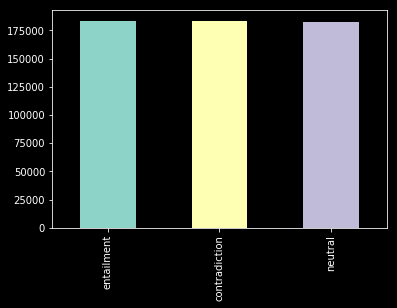

In [28]:
train.label.value_counts().plot(kind='bar')

It is good that data is uniformly distributed across all classes

# Baseline

In [314]:
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

nb_pipe = make_pipeline(TfidfVectorizer(), LogisticRegression())

In [315]:
def nb_prepare(df):
    return df.assign(concat=[t1 + " " + t2 for t1,t2 in zip(df['sentence1'], df['sentence2'])])

In [316]:
nb_data = nb_prepare(train)
nb_test = nb_prepare(test)

In [317]:
nb_pipe.fit(nb_data['concat'], nb_data['label'])

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [318]:
nb_pipe.score(nb_data['concat'], nb_data['label'])

0.591103943265613

In [340]:
print(classification_report(nb_test['label'], nb_pipe.predict(nb_test['concat'])))

               precision    recall  f1-score   support

contradiction       0.57      0.56      0.57      3237
   entailment       0.58      0.61      0.59      3368
      neutral       0.57      0.55      0.56      3219

  avg / total       0.57      0.57      0.57      9824



Simple idea like concatenating sentences and train logistic regression on it give pretty good results: f1=**57%**. So I will try to beat this results, but it may be not so easy.

# WordNet classifier

In [13]:
from nltk.corpus import wordnet as wn

In [14]:
def spacy2wn(spacy_pos):
    if spacy_pos == 'NOUN':
        return 'n'
    elif spacy_pos == 'VERB':
        return 'v'
    else:
        return 'NONE'

In [126]:
from textblob import Word
from tqdm import tqdm_pandas
tqdm_notebook().pandas()

In [222]:
train2 = train.assign(sentence1_doc=train['sentence1'].progress_apply(nlp))
train2 = train2.assign(sentence2_doc=train['sentence2'].progress_apply(nlp))

In [228]:
test2 = test.assign(sentence1_doc=test['sentence1'].progress_apply(nlp))
test2 = test2.assign(sentence2_doc=test['sentence2'].progress_apply(nlp))

In [247]:

cache = {}

def synset(id):
    res = None #cache.get(id)
    if res == None:
        res = wn.synset(id)
        cache[id] = res
    return res

def extract_features(df):
    features_list = []
    for i,row in tqdm_notebook(df.iterrows(), total=len(df)):
        sent1 = list(filter(lambda x: x.pos_ in {'NOUN', 'VERB'}, row['sentence1_doc']))
        sent2 = list(filter(lambda x: x.pos_ in {'NOUN', 'VERB'}, row['sentence2_doc']))

        sent1_uniq = set()
        sent2_uniq = set()
        features = {
            'synonym': 0,
            'hypernym': 0,
            'hyponym': 0,
            'holonym': 0,
            'meronym': 0,
            's1-ent->s2': 0,
            's2-ent->s1': 0
        }
        for i in range(len(sent1)):
            for j in range(len(sent2)):
                dist = abs(i-j)+1
                t1 = sent1[i]
                t2 = sent2[j]
                if t1.pos == t2.pos:
                    try:
                        s1 = synset(t1.lemma_ + '.' + spacy2wn(t1.pos_) + '.01')
                        s2 = synset(t2.lemma_ + '.' + spacy2wn(t2.pos_) + '.01')
                    except:
                        continue
                    features['synonym'] += (1 if t2.lemma_ in s1.lemma_names() else 0) / dist
                    features['hypernym'] += (1 if any([s1 in hypernyms for hypernyms in s2.hypernym_paths()]) else 0) / dist
                    features['hyponym'] += (1 if any([s2 in hypernyms for hypernyms in s1.hypernym_paths()]) else 0) / dist
                    features['holonym'] += (1 if s1 in list(s2.closure(lambda x: x.member_holonyms() + x.part_holonyms() + x.substance_holonyms())) else 0) / dist
                    features['meronym'] += (1 if s2 in list(s1.closure(lambda x: x.member_holonyms() + x.part_holonyms() + x.substance_holonyms())) else 0) / dist
                    features['s1-ent->s2'] += (1 if s1 in list(s2.closure(lambda x: x.entailments())) else 0) / dist
                    features['s2-ent->s1'] += (1 if s2 in list(s1.closure(lambda x: x.entailments())) else 0) / dist
        features_list.append(features)
        
    return features_list

In [227]:
features_list = extract_features(train)

In [248]:
test_features = extract_features(test2)

Try to train Logistic regression on this featuers

In [258]:
from sklearn.feature_extraction import DictVectorizer
pipe1 = make_pipeline(DictVectorizer(), LogisticRegression())
pipe1.fit(features_list, train2['label'])
train_score1 = pipe1.score(features_list, train2['label'])
print('train_score:', train_score1)
test_pred1 = pipe1.predict(test_features)
print(classification_report(test2['label'], test_pred1))

train_score: 0.4061984065296969
               precision    recall  f1-score   support

contradiction       0.41      0.62      0.49      3237
   entailment       0.44      0.47      0.45      3368
      neutral       0.33      0.13      0.19      3219

  avg / total       0.39      0.41      0.38      9824



Try to train random forest on this features

In [259]:
from sklearn.ensemble import RandomForestClassifier

pipe2 = make_pipeline(DictVectorizer(), RandomForestClassifier())
pipe2.fit(features_list, train2['label'])
train_score2 = pipe2.score(features_list, train2['label'])
print('train_score:', train_score2)
test_pred2 = pipe2.predict(test_features)
print(classification_report(test2['label'], test_pred2))

train_score: 0.4581727697513684
               precision    recall  f1-score   support

contradiction       0.46      0.51      0.48      3237
   entailment       0.44      0.62      0.52      3368
      neutral       0.39      0.17      0.24      3219

  avg / total       0.43      0.44      0.41      9824



Random forest gave the best results for this features set. But we are much belowe the baseline still.

# GloVe classifier
Let's try to use glove vectors for evidence and hypothesis to train classifier. For each sentence we will sum up all word vectors and than concatenate two resulting vectors into one

In [272]:
glove_file = open('dataset/glove.6B/glove.6B.100d.txt')
embedding_index = {}
for line in tqdm_notebook(glove_file, total=400000):
    parts = line.split()
    word = parts[0]
    vector = np.asarray([float(p) for p in parts[1:]])
    embedding_index[word] = vector

In [297]:
import sklearn.base

class SentenceEmbeddingExtractor(sklearn.base.TransformerMixin):
    def __init__(self, embedding_index):
        self.embedding_index = embedding_index
        
    def fit(self, X=None, y=None):
        self.unk = np.zeros((embedding_index['the'].shape[0],))
        return self
    
    def transform(self, sentences):
        return np.asarray([
            np.sum(np.asarray([self.embedding_index.get(token.lemma_, self.unk)  for token in sentence]), axis=0)
            for sentence in sentences
        ])

In [300]:
class ItemSelector(sklearn.base.TransformerMixin):
    def __init__(self, key):
        self.key = key
        
    def fit(self, X=None, y=None):
        return self
    
    def transform(self, df):
        return df[self.key]

In [320]:
pipe3 = make_pipeline(
    FeatureUnion(
        transformer_list=[
            ('embeddings1', make_pipeline(ItemSelector('sentence1_doc'), 
                                          SentenceEmbeddingExtractor(embedding_index))),
            
            ('embeddings2', make_pipeline(ItemSelector('sentence2_doc'), 
                                          SentenceEmbeddingExtractor(embedding_index))),
        ]
    ),
    LogisticRegression()
)

pipe3.fit(train2, train2['label'])
train_score3 = pipe3.score(train2, train2['label'])
print('train_score:', train_score3)
test_pred3 = pipe3.predict(test2)
print(classification_report(test2['label'], test_pred3))

train_score: 0.5502405495779689
               precision    recall  f1-score   support

contradiction       0.55      0.53      0.54      3237
   entailment       0.56      0.61      0.58      3368
      neutral       0.57      0.52      0.54      3219

  avg / total       0.56      0.56      0.56      9824



With **f1 = 56%** are pretty close to the baseline results (57%) 

# WordNet and GloVe classifier
Here we will try to concatenate wordnet features vector to the embeddings vector and train logistic regression on it

In [323]:
train3 = train2.assign(wn_features=features_list)
test3 = test2.assign(wn_features=test_features)

In [339]:
pipe4 = make_pipeline(
    FeatureUnion(
        transformer_list=[
            ('embeddings1', make_pipeline(ItemSelector('sentence1_doc'), 
                                          SentenceEmbeddingExtractor(embedding_index))),
            
            ('embeddings2', make_pipeline(ItemSelector('sentence2_doc'), 
                                          SentenceEmbeddingExtractor(embedding_index))),
            
            ('wn_features', make_pipeline(ItemSelector('wn_features'),
                                          DictVectorizer()))
        ]
    ),
    LogisticRegression()
)
pipe4.fit(train3, train3['label'])
train_score4 = pipe4.score(train3, train3['label'])
print('train_score:', train_score4)
test_pred4 = pipe4.predict(test3)
print(classification_report(test3['label'], test_pred4))

train_score: 0.578489425101981
               precision    recall  f1-score   support

contradiction       0.58      0.58      0.58      3237
   entailment       0.60      0.66      0.63      3368
      neutral       0.58      0.51      0.54      3219

  avg / total       0.59      0.59      0.59      9824



Nice, we've beaten the baseline results by 3%. Not so much, but definetely a good start.

# Results

Word embedding with wordnet features gives us good results for this task, but there are some of thigs to try:
* Try longer word vector (> 100)
* Try to use more smooth function for penalizing wordnet features. `(1, 1/2, 1/3, 1/4, 1/5, ..)` is not so smooth at the beggining.
* Try to normalize result number for sentence from wordnet features by the length of sentence.
* (as always) try different classifier (NN or other non-linear)
* (as always) do hyperparameters search